##  <p style="text-align: center; margin-top: 0;"> 'Momentum and Trend Following Trading Strategies for Currencies and Bitcoin'<p>
<p style="text-align: center; margin-top: 0;"> Catalina Amaris, Zineb Azili, Jean-Yves Cambier, Raphael Monges, Clément Seniquette <p>

### I - Introduction

Les stratégies de trading basées sur le momentum et le suivi de tendance sont très populaires et beaucoup utilisées en finance. Dans leur papier 'Momentum and Trend Following Trading Strategies for Currencies and Bitcoin', les auteurs présentent la stratégie adoptée par Baz et al. (2015) et l'appliquent à divers types d'actifs, dont les devises du G10, des marchés émergents et des crypto-monnaies, et ce à travers deux différents types de portefeuilles. 

Ce projet a pour but dans un premier temps de présenter et de répliquer les résultats de cette étude. Par la suite, nous mettrons en place les stratégies de trading décrites et effectuerons un backtest pour évaluer leurs performances avec les données passées et actuelles.

### II - Données

Les fonctions ainsi que les constantes sont accessibles dans le code ou sur le lien github suivant - https://github.com/jycambierescp/projet_python

In [1]:
import datetime

import pandas as pd

from matplotlib import pyplot as plt

from constants import (
    G10_CURRENCIES, 
    EM_CURRENCIES, 
    CRYPTO_CURRENCIES,
    SHORT_EMA_PERIODS,
    LONG_EMA_PERIODS,
)

from data import (
    calculate_arithmetic_returns,
    get_arithmetic_return,
    get_normalization,
    get_ema,
    get_data,
    get_geometric_brownian_motion,
    get_moving_standard_deviation,
    get_signal_uk,
    get_xks,
    plot_time_series,
    plot_returns,
    plot_histogram,
    plot_lines,
    plot_two_series,
    weighted_sum
)

La librairie yahoo_finance est utilisée pour extraire les données des trois datasets. 

Nous n'avons pas réussi à extraire des données datants des années 1990 sur yahoo finance, nous avons donc mis à jour les datasets avec des données plus récentes. 

Pour le dataset G10, nous avons utilisé comme date de commencement le 1er Décembre 2003 et comme date de fin le 1er Janvier 2023. Au total, nous avons 8 devises différentes.

Pour le dataset Emerging Markets, nous avons utilisé comme date de commencement le 24 Mars 2004 et comme date de fin le 1er Janvier 2023. Au total, nous avons 7 devises différentes.

Pour le dataset des crypto-monnaies, nous n'avons pas réussi à extraire des données datants d'avant 2014 sur yahoo finance. Nous avons décidé de 'mettre à jour' ce dataset en utilisant sept des quinze crypto-monnaies ayant la capitalisation boursière la plus élevée en Mars 2023 et un historique de données conséquent (même méthodologie que les auteurs): BTC, ETH, ADA, SOL, BNB, LTC, DOGE. 
Nous avons choisi le 9 Novembre 2017 comme date de commencement et le 1er Janvier 2023 comme date de fin.

In [2]:
g10_currencies = get_data(
    G10_CURRENCIES,
    start_date=datetime.datetime(2003, 12, 1),
    end_date=datetime.datetime(2023, 1, 1)
)
em_currencies = get_data(
    EM_CURRENCIES,
    start_date=datetime.datetime(2003, 12, 1),
    end_date=datetime.datetime(2023, 1, 1)
)
crypto_currencies = get_data(
    CRYPTO_CURRENCIES,
    start_date=datetime.datetime(2017, 1, 1),
    end_date=datetime.datetime(2023, 1, 1)
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Les trois datasets présentent la même structure -

In [3]:
crypto_currencies["BTC-USD"].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


#### Taux de change & Rendements EUR/USD

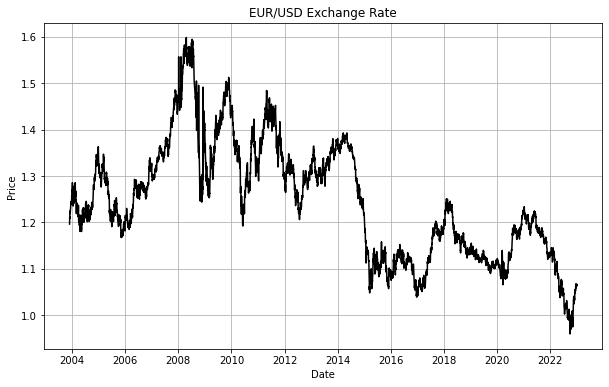

In [4]:
plot_time_series(g10_currencies["EURUSD=X"].Close, "EUR/USD Exchange Rate")

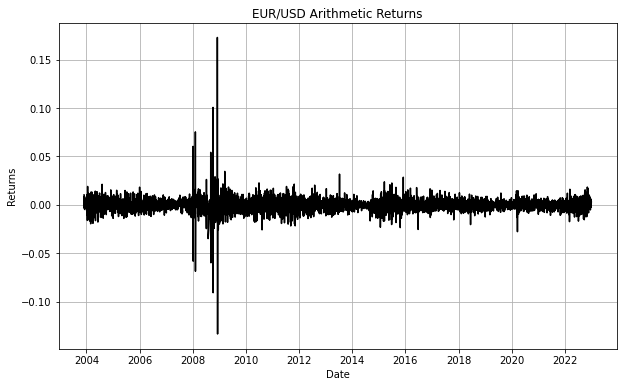

In [5]:
eurusd_returns = get_arithmetic_return(g10_currencies["EURUSD=X"].Close)
plot_returns(eurusd_returns, 'EUR/USD Arithmetic Returns')

####  Taux de change & Rendements INR/USD

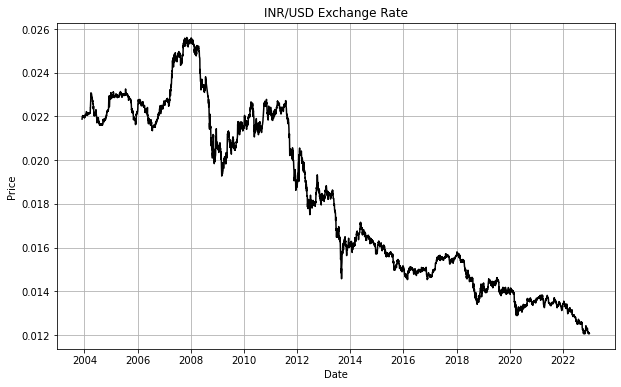

In [6]:
plot_time_series(em_currencies["INRUSD=X"].Close, "INR/USD Exchange Rate")

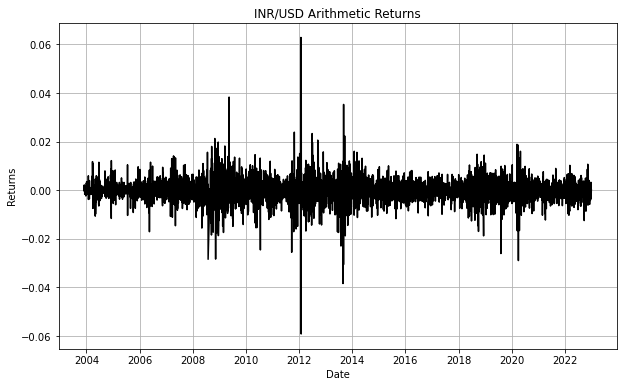

In [7]:
inrusd_returns = get_arithmetic_return(em_currencies["INRUSD=X"].Close)
plot_returns(inrusd_returns, 'INR/USD Arithmetic Returns')

####  Taux de change & Rendements BTC/USD

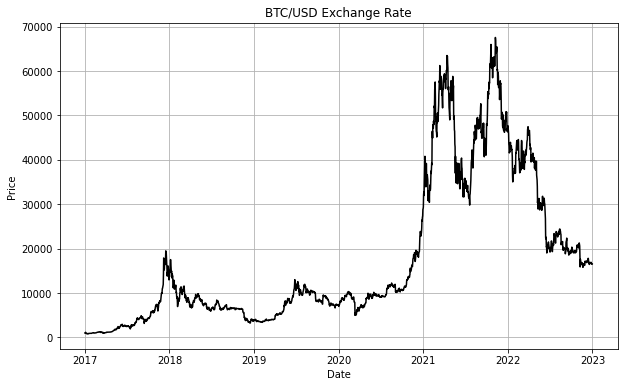

In [8]:
plot_time_series(crypto_currencies["BTC-USD"].Close, "BTC/USD Exchange Rate")

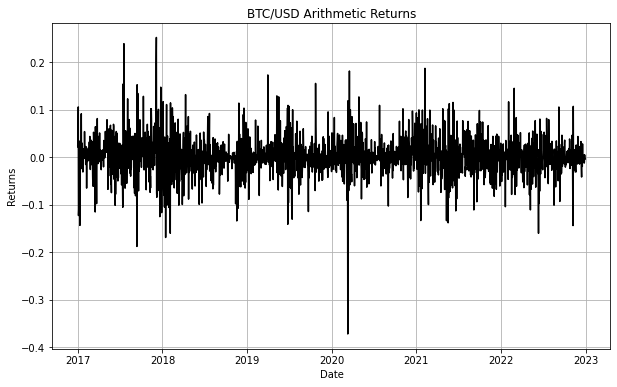

In [9]:
btcusd_returns = get_arithmetic_return(crypto_currencies["BTC-USD"].Close)
plot_returns(btcusd_returns, 'BTC/USD Arithmetic Returns')

### III - Présentation de la Stratégie sur des Rendement Normaux

Afin de simuler un taux de change avec des rendements normalement distribués, un mouvement brownien géométrique (GBM) a été simulé avec les paramètres utilisés dans le papier:

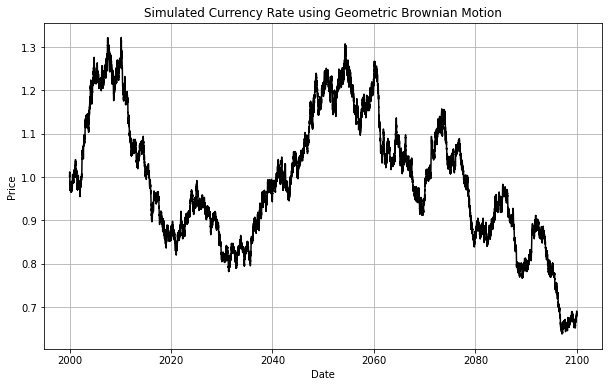

In [10]:
# Paramètres
P0 = 1.0
mu = 0.0
sigma = 0.05
T = 100
dt = 1/365.24

currency_rate = get_geometric_brownian_motion(P0, mu, sigma, T, dt)

# Dates fictives
start_date = pd.to_datetime('2000-01-01')
date_range = pd.date_range(start=start_date, periods=len(currency_rate), freq='D')
df_gbm = pd.DataFrame({'Date': date_range, 'Close': currency_rate})
df_gbm.set_index('Date', inplace=True)

plot_time_series(df_gbm, "Simulated Currency Rate using Geometric Brownian Motion")

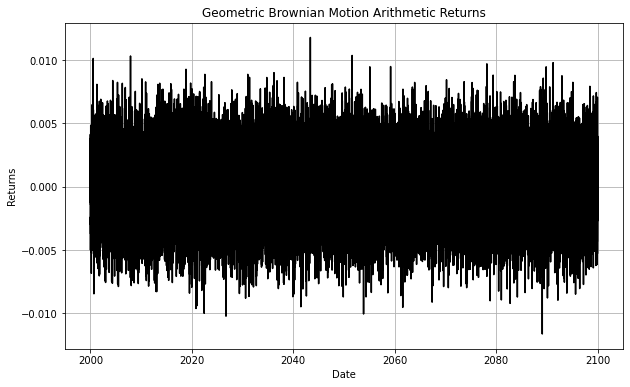

In [11]:
gbm_returns = get_arithmetic_return(df_gbm.Close)
plot_returns(gbm_returns, 'Geometric Brownian Motion Arithmetic Returns')

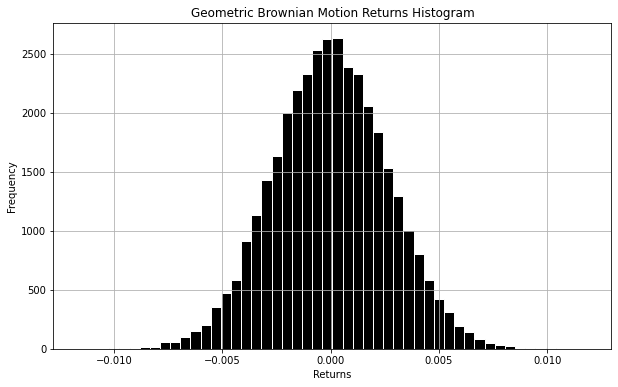

In [12]:
plot_histogram(gbm_returns, 'Geometric Brownian Motion Returns Histogram')

On observe ici que les rendements semblent être normalement distribués. 

Afin d'analyser le rôle des moyennes mobiles exponentielles, nous prenons les 365 premiers points de cette simulation pour représenter une année.

In [13]:
gbm_returns_one_year = pd.DataFrame(currency_rate).iloc[:365]

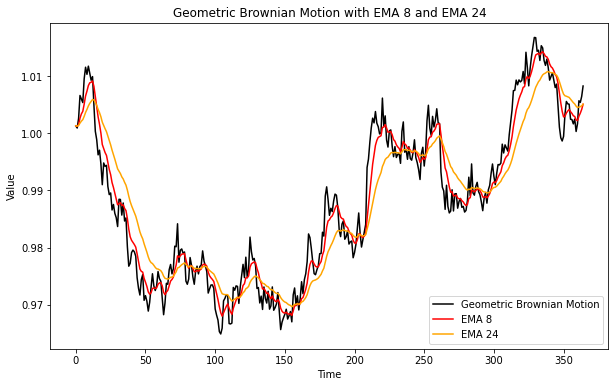

In [14]:
ema8 = get_ema(gbm_returns_one_year, 8)
ema24 = get_ema(gbm_returns_one_year, 24)

plot_lines(
    [gbm_returns_one_year, ema8, ema24],
    labels=['Geometric Brownian Motion', 'EMA 8', 'EMA 24'],
    colors=['black', 'red', 'orange'],
    title='Geometric Brownian Motion with EMA 8 and EMA 24',
    xlabel='Time',
    ylabel='Value'
)

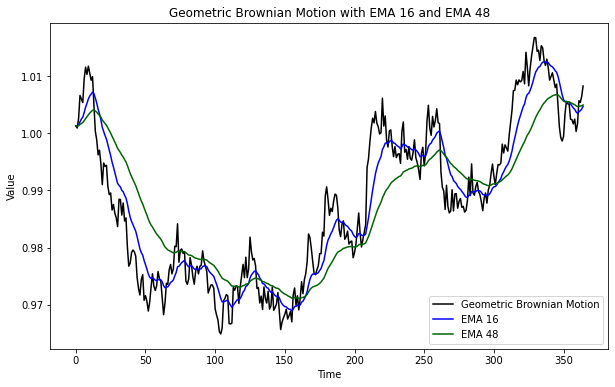

In [15]:
ema16 = get_ema(gbm_returns_one_year, 16)
ema48 = get_ema(gbm_returns_one_year, 48)

plot_lines(
    [gbm_returns_one_year, ema16, ema48],
    labels=['Geometric Brownian Motion', 'EMA 16', 'EMA 48'],
    colors=['black', 'blue', 'darkgreen'],
    title='Geometric Brownian Motion with EMA 16 and EMA 48',
    xlabel='Time',
    ylabel='Value'
)

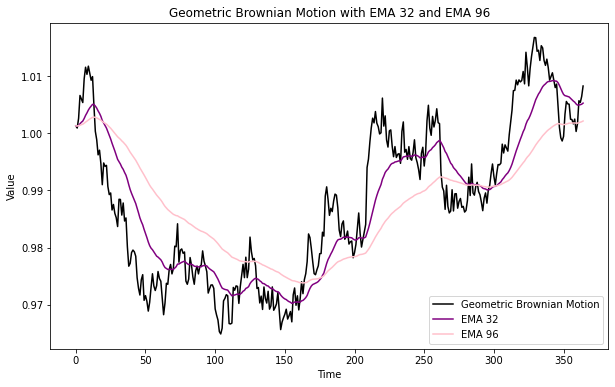

In [16]:
ema32 = get_ema(gbm_returns_one_year, 32)
ema96 = get_ema(gbm_returns_one_year, 96)

plot_lines(
    [gbm_returns_one_year, ema32, ema96],
    labels=['Geometric Brownian Motion', 'EMA 32', 'EMA 96'],
    colors=['black', 'purple', 'pink'],
    title='Geometric Brownian Motion with EMA 32 and EMA 96',
    xlabel='Time',
    ylabel='Value'
)

Comme mentionné dans le papier, lorsque l'EMA courte est supérieure à l'EMA longue, cela indique une tendance positive, tandis que si l'EMA courte est inférieure à l'EMA longue, la tendance est négative. Cependant, on peut observer que plus la période EMA est longue, plus il y a un délai lors du changement de tendance: les EMAs plus longues sont donc moins sensibles aux fluctuations locales.

Les auteurs proposent ensuite d'utiliser x<sub>k</sub> = EMA<sub>courte</sub> - EMA<sub>longue</sub> comme premier signal. Ce signal est utilisé avec les périodes suivantes: 8, 16, 32 pour les courtes et 24, 48, 96 pour les longues.


Ainsi, le signe de x<sub>k</sub> détermine si nous prenons une position long ou short: si x<sub>k</sub> est positif, l'EMA courte est au dessus et de l'EMA longue et il faut donc privilégier les positions longues car on est en tendance haussière, et inversement.

In [17]:
xks = get_xks([ema8, ema16, ema32], [ema24, ema48, ema96])

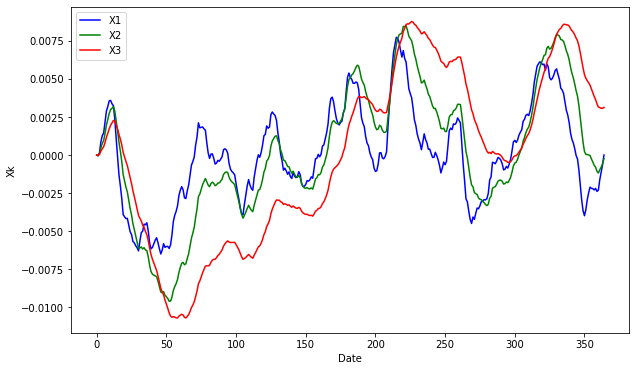

In [18]:
plot_lines(
    [xks["x_1"],xks["x_2"], xks["x_3"]],
    labels=['X1', 'X2', 'X3'],
    colors=['blue', 'green', 'red'],
    xlabel='Date',
    ylabel='Xk'
)

On peut voir ici que la notion x<sub>k</sub> positive / négative et tendance haussière / baissière est assez fiable. 

En ce qui concerne la corrélation de chaque x<sub>k</sub>, on retrouve bien les mêmes que les auteurs.

In [19]:
combined_emas = pd.concat([xks["x_1"], xks["x_2"], xks["x_3"]], axis=1)
combined_emas.columns = ['EMA1', 'EMA2', 'EMA3']
correlation_matrix = combined_emas.corr()
print(correlation_matrix)

          EMA1      EMA2      EMA3
EMA1  1.000000  0.849091  0.526281
EMA2  0.849091  1.000000  0.856299
EMA3  0.526281  0.856299  1.000000


Puis, les auteurs proposent de normaliser en deux temps ces valeurs x<sub>k</sub>. Dans un premier temps avec l'écart type mobile de 3 mois, puis l'écart type mobile d'1 an sur les valeurs déjà normalisées.

Cette transformation a pour but d'abaisser les signaux d'achat / vente en période de haute volatilité, et des les intensifier lorsque la volatilité baisse. 

In [20]:
yk = get_normalization(xks["x_1"], prices=gbm_returns_one_year, period=63)
zk = get_normalization(yk, period=252)

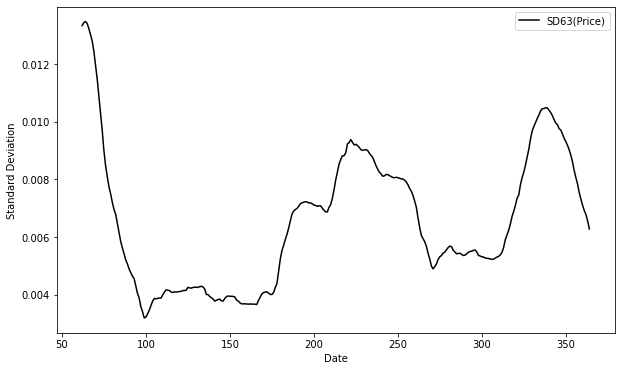

In [21]:
gbm_volatility = get_moving_standard_deviation(gbm_returns_one_year, period=63)
plot_lines(
    [gbm_volatility],
    labels=['SD63(Price)'],
    colors=['black'],
    xlabel='Date',
    ylabel='Standard Deviation'
)

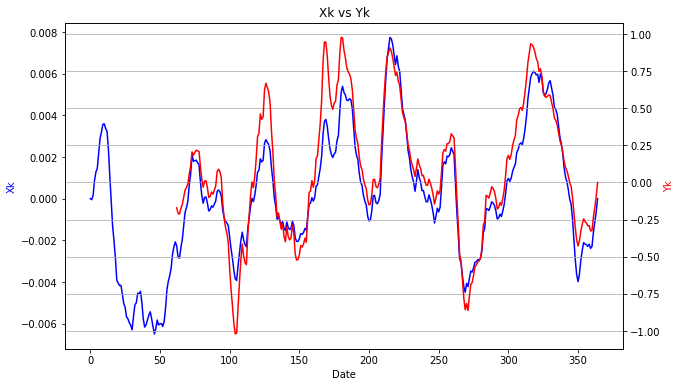

In [22]:
plot_two_series(
    series1=xks["x_1"],
    series2=yk,
    label1='Xk',
    label2='Yk',
    color1='blue',
    color2='red',
    title='Xk vs Yk',
)

On peut voir ici qu'en superposant les deux graphes, x<sub>k</sub> est amorti durant les phases de haute volatilité, et inversement.

In [23]:
gbm_returns_two_years = pd.DataFrame(currency_rate).iloc[:730]
ema8 = get_ema(gbm_returns_two_years, 8)
ema16 = get_ema(gbm_returns_two_years, 16)
ema32 = get_ema(gbm_returns_two_years, 32)
ema24 = get_ema(gbm_returns_two_years, 24)
ema48 = get_ema(gbm_returns_two_years, 48)
ema96 = get_ema(gbm_returns_two_years, 96)

xks_two_years = get_xks([ema8, ema16, ema32], [ema24, ema48, ema96])

y1 = get_normalization(xks_two_years["x_1"], prices=gbm_returns_two_years, period=63)
z1 = get_normalization(y1, period=252)

y2 = get_normalization(xks_two_years["x_2"], prices=gbm_returns_two_years, period=63)
z2 = get_normalization(y2, period=252)

y3 = get_normalization(xks_two_years["x_3"], prices=gbm_returns_two_years, period=63)
z3 = get_normalization(y3, period=252)

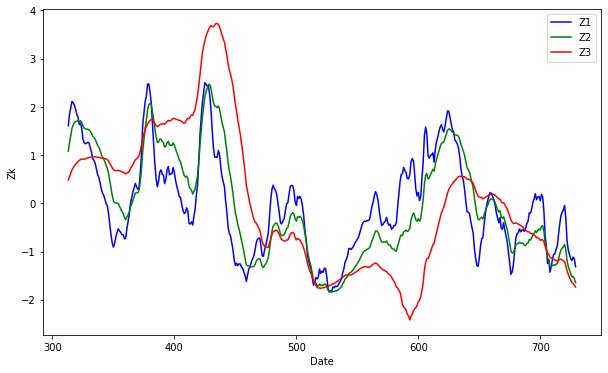

In [24]:
plot_lines(
    [z1, z2, z3],
    labels=['Z1', 'Z2', 'Z3'],
    colors=['blue', 'green', 'red'],
    xlabel='Date',
    ylabel='Zk'
)

La seconde normalisation vient amplifier cette transformation. Néanmoins, il faut prendre en compte que ces transformations vont allonger la période 'd'échauffement' de la stratégie, durant laquelle aucun signal ne pourra être généré. Le signal de vente / achat peut donc être généré après $62+252 = 314$ jours.

Les valeurs z<sub>k</sub> sont transformées pour être comprises entre -1 et 1. Les auteurs utilisent la fonction suivante:

<p style="text-align: center"> $$ u_k(z_k) = { z_k*e^{-z^2_k/4} \over \sqrt(2)*e^{(-1/2)}} $$ </p>

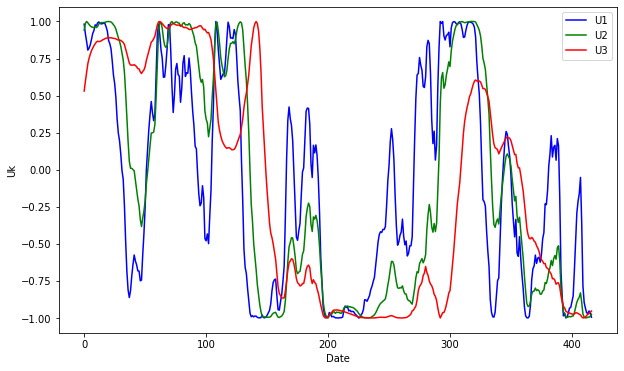

In [25]:
u1 = [get_signal_uk(x) for x in z1[0].dropna()]
u2 = [get_signal_uk(x) for x in z2[0].dropna()]
u3 = [get_signal_uk(x) for x in z3[0].dropna()]

plot_lines(
    [u1, u2, u3],
    labels=['U1', 'U2', 'U3'],
    colors=['blue', 'green', 'red'],
    xlabel='Date',
    ylabel='Uk'
)

Enfin, le signal est calculé en prenant la somme pondérée de chaque u<sub>k</sub>. Pour des raisons de simplicité, les auteurs utilisent des poids égaux. 

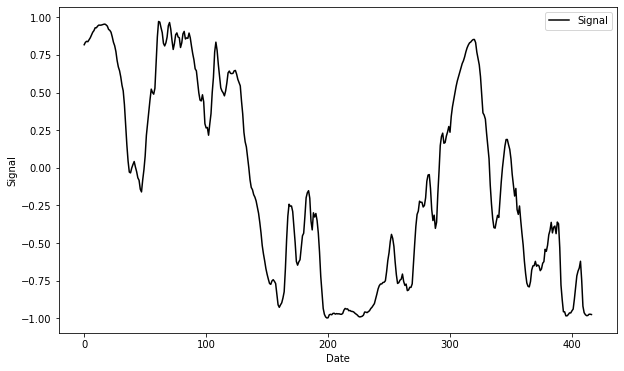

In [26]:
signals = []
for u1_value, u2_vlaue, u3_value in zip(u1, u2, u3):
    signals.append(weighted_sum([u1_value, u2_vlaue, u3_value], [1/3,1/3,1/3]))

plot_lines(
    [signals],
    labels=['Signal'],
    colors=['black'],
    xlabel='Date',
    ylabel='Signal'
)

Voici le signal final, comparons maintenant le signal généré pour cette période avec le mouvement brownien.

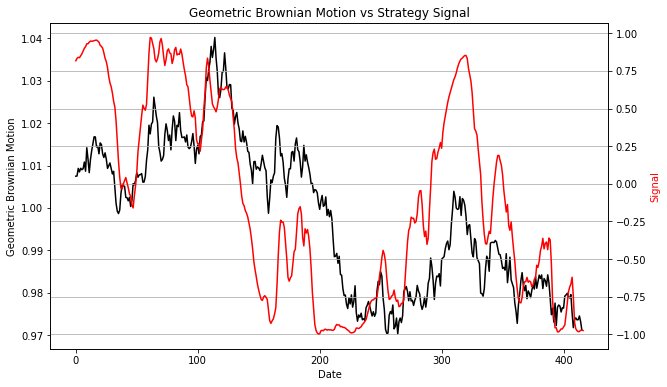

In [27]:
gbm_currency_rate = pd.DataFrame(currency_rate).iloc[314:730].reset_index(drop=True)

plot_two_series(
    series1=gbm_currency_rate,
    series2=pd.DataFrame(signals),
    label1='Geometric Brownian Motion',
    label2='Signal',
    color1='black',
    color2='red',
    title='Geometric Brownian Motion vs Strategy Signal',
)

On peut voir ici que le signal de la stratégie semble cohérent avec le mouvement brownien. Lorsque le signal est positif / augmente, le mouvement est bien en tendance haussière et inversement. On repère également les changements de tendance et leur impact sur le signal: aux ~110 et ~310, le signal fortement positif commence à baisser au moment où la tendance locale change. 

### III - Portfolios

#### Portefeuille Séries Temporelles

Ce portefeuille est réequlibré à chaque début de journée. À chaque date, on investit dans toutes les devises en fonction de la valeur du signal divisée par n (nombre de devises dans le portefeuille). Pour un signal de 1 pour le BTC par exemple, on achète ${1 \over n }$ unités de BTC. Pour un signal de -1, on vend ${1 \over n }$ unités de BTC. La valeur d'une unité dépend du portfeuille.

#### Portefeuille Transversal

Ce portefeuille est également réequilibré à chaque début de journée. Cependant, il nécessite d'avoir au moins $n = 6$ devises en portefeuille. En effet, en fonction des signaux renvoyés, on achète les trois devises ayant le signal le plus élevé et vend les trois devises ayant le signal le plus faible. On achète ou vend toujours exactement ${1 \over 6 }$ unités d'USD de chaque devise. 

### IV - Backtest

La librairie <em>Backtrader</em> a été utilisée pour le backtest des stratégies. L'implémentation des stratégies de portefeuille et du calcul du signal sont accessibles sur le repo github. 

In [39]:
import pprint

import backtrader as bt

from strategies import (
    Data,
    TimeSeriesPortfolioStrategy,
)

from backtest import run_backtest

pp = pprint.PrettyPrinter(indent=4)

def print_returns(data):
    all_returns = []
    for date, value in data.items():
        year = date.year
        return_percentage = value * 100
        print(f"{year}: {return_percentage:.2f}%")
        all_returns.append(value)
    average = sum(all_returns) / len(all_returns)
    average_return_percentage = average * 100
    print(f"Average annual return : {average_return_percentage:.2f}%")
    
def print_standard_deviation(data):
    for date, value in data.items():
        print(f"{date}: {value}")

#### A - G10

<u> <strong> Portefeuille Série Temporelle </strong></u>

In [40]:
results, cerebro = run_backtest(
    g10_currencies,
    portfolio="time_series",
    three_months_std_dev_period=63,
    one_year_std_dev_period=252
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2003: 0.00%
2004: 0.00%
2005: -0.01%
2006: -0.05%
2007: 0.09%
2008: 1.23%
2009: -0.08%
2010: 0.04%
2011: -0.32%
2012: -0.09%
2013: -0.54%
2014: 0.74%
2015: -0.10%
2016: -0.41%
2017: -0.24%
2018: 0.12%
2019: -0.27%
2020: 0.19%
2021: -0.29%
2022: 0.36%
Average annual return : 0.02%

Annualized Sharpe Ratio:
-2.5177556008832727

Annualized Standard Deviation: 
2003: 0.0
2004: 0.0
2005: -0.0009516250602163989
2006: 0.0005870088444934751
2007: 0.0009165433466593598
2008: 0.011437672015265132
2009: -0.000245978189037821
2010: 0.0004440803114544867
2011: -0.003541801384148502
2012: -0.000645513345370774
2013: -0.005399332989834971
2014: 0.007355443554245111
2015: -0.0009596848167421346
2016: -0.0040723248663733225
2017: -0.0023899307097881017
2018: 0.001197565829645475
2019: -0.0026917878685553953
2020: 0.0018649040801317351
2021: -0.002931989180131378
2022: 0.0036346284713786314


<u> <strong> Portefeuille Transversal </strong> </u>

In [41]:
results, cerebro = run_backtest(
    g10_currencies,
    portfolio="cross_sectional",
    three_months_std_dev_period=63,
    one_year_std_dev_period=252
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2003: 0.00%
2004: 0.00%
2005: 0.32%
2006: 0.21%
2007: -0.12%
2008: 0.18%
2009: -0.16%
2010: -0.05%
2011: -0.10%
2012: 0.09%
2013: -0.09%
2014: 0.18%
2015: -0.20%
2016: 0.20%
2017: 0.16%
2018: 0.00%
2019: 0.05%
2020: 0.23%
2021: -0.05%
2022: 0.31%
Average annual return : 0.06%

Annualized Sharpe Ratio:
-6.137871667904622

Annualized Standard Deviation: 
2003: 0.0
2004: 0.0
2005: 0.0035076848267339145
2006: 0.0019079565196427062
2007: -0.001440223542614305
2008: 0.0016727676413617054
2009: -0.0012012833658054944
2010: -0.0006571776551081987
2011: -0.0009699440067325593
2012: 0.0009405722430575469
2013: -0.000907146185502028
2014: 0.001816323810007514
2015: -0.001953599049646204
2016: 0.002022989064355052
2017: 0.001567981703728183
2018: 5.79268925937626e-06
2019: 0.0005415676712412498
2020: 0.002293651721586576
2021: -0.0005169370126880679
2022: 0.0031496248071007926


#### Emerging Markets

<u> <strong> Portefeuille Série Temporelle </strong></u>

In [42]:
results, cerebro = run_backtest(
    em_currencies,
    portfolio="time_series",
    three_months_std_dev_period=63,
    one_year_std_dev_period=252
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2003: 0.00%
2004: 0.00%
2005: 0.00%
2006: 0.05%
2007: -0.17%
2008: 1.30%
2009: 0.04%
2010: -0.28%
2011: 0.17%
2012: 0.02%
2013: 2581.89%
2014: -0.35%
2015: 0.38%
2016: -0.01%
2017: 0.00%
2018: 0.01%
2019: -0.02%
2020: 0.03%
2021: -0.02%
2022: 0.00%
Average annual return : 129.15%

Annualized Sharpe Ratio:
0.22774557894721031

Annualized Standard Deviation: 
2003: 0.0
2004: 0.0
2006: 0.0004679253013153417
2007: -0.0016101785741065022
2008: 0.011423777738749363
2009: 0.0024600202627007572
2010: -0.004131977007785559
2011: 0.0016742185290652412
2012: 0.0006543055667451725
2013: 25.82640759571588
2014: 0.00012059808244213599
2015: 0.00018747978076061322
2016: -0.00013310226084850552
2017: 1.1777351227371113e-05
2018: 5.392049161989654e-05
2019: -0.00017111046838791388
2020: 0.0002727635207022683
2021: -0.00015448356338354507
2022: 1.2123632695759667e-05


<u> <strong> Portefeuille Transversal </strong> </u>

In [43]:
results, cerebro = run_backtest(
    em_currencies,
    portfolio="cross_sectional",
    three_months_std_dev_period=63,
    one_year_std_dev_period=252
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2003: 0.00%
2004: 0.00%
2005: 0.00%
2006: -0.09%
2007: -0.02%
2008: 0.74%
2009: -0.07%
2010: 0.23%
2011: 0.03%
2012: -0.26%
2013: 0.05%
2014: -0.27%
2015: -0.02%
2016: -0.23%
2017: -0.25%
2018: 0.04%
2019: -0.18%
2020: 0.14%
2021: -0.06%
2022: -0.24%
Average annual return : -0.02%

Annualized Sharpe Ratio:
-4.623705860268572

Annualized Standard Deviation: 
2003: 0.0
2004: 0.0
2006: -0.0005590792115673926
2007: 0.0013608591380869228
2008: 0.004323640297546616
2009: 0.0006410218295311854
2010: 0.0018438514724290478
2011: 0.0006465130708890321
2012: -0.0024103818114058484
2013: 0.00015784927153328354
2014: -0.002465435174149988
2015: -0.00037442869624215724
2016: -0.00244565834599475
2017: -0.0023726435028477155
2018: 0.00043029753725143394
2019: -0.0018307972433081465
2020: 0.001359445883694299
2021: -0.0005537149919122575
2022: -0.0023815963580082755


#### Crypto Monnaies

<u> <strong> Portefeuille Série Temporelle </strong></u>

In [44]:
results, cerebro = run_backtest(
    crypto_currencies,
    portfolio="time_series",
    three_months_std_dev_period=91,
    one_year_std_dev_period=365
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2017: 0.00%
2018: 0.00%
2019: 0.00%
2020: 4.80%
2021: 19.62%
2022: 2.14%
Average annual return : 4.43%

Annualized Sharpe Ratio:
0.4887827524579212

Annualized Standard Deviation: 
2017: 0.0
2018: 0.0
2019: 0.0
2020: 0.04801043561820073
2021: 0.19616492935092245
2022: 0.021419384210467518


<u> <strong> Portefeuille Transversal </strong></u>

In [46]:
results, cerebro = run_backtest(
    crypto_currencies,
    portfolio="cross_sectional",
    three_months_std_dev_period=91,
    one_year_std_dev_period=365
)

annual_return = results[0].analyzers.annual_return.get_analysis()
annual_sharpe_ratio = results[0].analyzers.annual_sharpe_ratio.get_analysis()["sharperatio"]
annual_std_dev = results[0].analyzers.annual_std_dev.get_analysis()

print("Annualized Return:")
print_returns(annual_return)
print()
print("Annualized Sharpe Ratio:")
pp.pprint(annual_sharpe_ratio)
print()
print("Annualized Standard Deviation: ")
print_standard_deviation(annual_std_dev)

Annualized Return:
2017: 0.00%
2018: 0.00%
2019: 0.00%
2020: -0.31%
2021: 6.07%
2022: -0.33%
Average annual return : 0.91%

Annualized Sharpe Ratio:
-0.041002757715176634

Annualized Standard Deviation: 
2017: 0.0
2018: 0.0
2019: 0.0
2020: -0.003086657749752697
2021: 0.060661316161567
2022: -0.003263582218454242


Les résultats trouvés pour chacun des datasets sont très différents de ceux trouvés par les auteurs. Ces différences peuvent s'expliquer de différentes manières. 


Premièrement, le backtest n'a pas été effectué sur les mêmes années. Comme mentionné dans le papier, les stratégies de momentum ne sont pas profitables depuis la crise de 2008, et backtester cette stratégie sur des années post 2017 ne peut pas générer les mêmes rendements qu'avant la crise. 


Deuxièmement, il est fort probable que les stratégies implémentées sur backtrader contiennent des bugs ou des paramètres qui n'ont pas été pris en compte. Le rendement annuel de 2582% en 2013 pour les données Emerging Markets souligne l'existence d'un bug que nous n'avons pas pu trouver pour le moment. De plus, nous avons supposé que toutes les positions étaient fermées à chaque date de re-équilibrage, ce qui n'est pas nécessairement le cas.

### V - Conclusion

En conclusion, la simulation de mouvement Brownien nous montre qu'une stratégie de momentum et de suivi de tendance peut s'avérer fiable et rentable, à condition d'avoir un bon risk management.

À l'avenir, il serait préférable de commencer par une stratégie plus simple, utilisée come baseline, et d'itérer sur cette stratégie pour mieux comprendre et mesurer l'impact de chacun des paramètres. Les auteurs suggèrent par exmple de faire un grid search sur différentes périodes EMA afin de trouver une combinaison optimale. On pourrait également combiner ces EMAs avec d'autres indicateurs de momentum, comme le RSI.